# Neural Network Model: Build, Train, Predict

The following notebook uses different feature sets to train a neural network. Along with using different feature sets, neural net parameters are changed and optimized to try to increase the accuracy. Once the optimum model is found, it is used to make predictions on the test_set data. Finally, the predictions are plotted to understand their distribution compared to the initial training data.

## Preliminaries

### Import Libraries

In [274]:
# data/math manipulation
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns instead of truncated list when using head/tail function
import numpy as np
import math
from numpy import errstate, isneginf

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# garbage collection
import gc

# file paths/saving
from pathlib import Path
import pickle
import h5py

# splitting training data
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import itertools

# nueral network libraries
import keras
from keras.models import Sequential, Input, Model, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, to_categorical

import time
import warnings

### Import Training Data

In [2]:
# create folder path where data lives
data_folder = Path('C:/Users/Kathleen Lange/MSDS692_Practicum_I')

In [3]:
# load feature sets from pickle files
feat_set1 = pd.read_pickle(data_folder / 'all_manual_features.pk')
feat_set1_scaled = pd.read_pickle(data_folder / 'all_manual_features_scaled.pk')
feat_set5_scaled = pd.read_pickle(data_folder / 'auto_FT_ss.pk')

# Feature sets 1, 2, 2scaled, 3, 4, and 5 all showed far worse performance after the first 
# few iterations of the neural network architecture than the above two feature sets. 
# I focus the rest of this notebook on optimizing the top two feature sets.

### Prepare Data for Model Input

The target variable needs to be separated from the rest of the features in the dataframe so the features can be fed to the neural net for training. Also, the target variable is a multi-class object and needs to be converted to be one-hot encoded for the nueral network to work correctly. 

In [4]:
def prep_data_for_NN(df):
    y_train = df['target'].astype('category')
    y_train = y_train.cat.codes
    y_train_OHC = to_categorical(y_train) # one-hot encoding y-values
    
    X_train = df.drop(columns=['target'])
    
    return X_train, y_train_OHC

In [50]:
X1_scaled_train, y1_scaled_train = prep_data_for_NN(feat_set1_scaled)
X5_scaled_train, y5_scaled_train = prep_data_for_NN(feat_set5_scaled)

In [64]:
X1_train, y1_train = prep_data_for_NN(feat_set1)
X1_train.reset_index(inplace=True)
X1_train.drop(columns=['origin'], inplace=True)

## Build Model

Initial build of Keras deep learning neural net followed from [this blog post](https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37). The steps in building the model are described below:  
- Using a sequential model allows you to build up the model layer by layer. 
- The number of columns/features is the shape of the input layer.
- The number of unique targets becomes the number of classes that can be predicted. This value becomes the number of neurons/nodes of the output layer.
- The number of nodes for each of the hidden layers is an important parameter to set. If there are too few nodes, then the model can result in underfitting. If there are too many nodes, then the model will take longer to train and can result in overfitting. This [blog post from Heaton Research](https://www.heatonresearch.com/2017/06/01/hidden-layers.html) suggests a couple of rule of thumbs for choosing the number of hidden layer nodes. For this project I have used the following formula:
    - (2/3)(number input features) + (number classes)
- Each layer is added to the model using the add() function. As a rule of thumb, start with one hidden layer to understand initial performance of the model along with the input layer and the output layer. Adding hidden layers allows the learning algorithm to exhibit non-linear behavior. 
- The 'Dense' option is a standard layer type that means that every node in one layer is connected to every node in the subsequent layer.
- The standard activation function used in hidden layers is the Rectified Linear Activation (relu). It is zero for values less than zero and a linear function for values greater than zero. Modifications of this activation function are the leaky relu which allows for some small negative values and the parametric relu which has a variable function for x < 0.
- The activation function for the final layer is 'softmax'. This allows the output to be summed to 1 so that the output can be interpreted as probabilities which is required for multi-class classification models.
- Once the model is built is needs to be compiled. The compiler takes the arguments, optimizer, loss and metrics. 
    - Optimizer controls the learning rate. Adam has been shown to be a good starting point for a optimizer because is adjusts the learning rate throughout the training stage.
    - The standard loss function for a classification model is categorical_crossentropy. A lower value for this loss function, the better the model is performing.
    - An easier way to interpret the model performance instead of using the loss values is to use the accuracy metric. The accuracy is determined on the test data at the end of every epoch.

In [6]:
def build_model(train):
    model = Sequential()
    
    n_cols = train.shape[1]
    n_classes = 14
        
    neurons = int((2/3)*n_cols + n_classes)
    
    model.add(Dense(neurons, activation='relu', input_shape=(n_cols,))) # input layer
    model.add(Dense(neurons, activation='relu')) # hidden layers...
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax')) # output layer
      
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [7]:
# compile models using different feature sets
model1_sc = build_model(X1_scaled_train)
model5_sc = build_model(X5_scaled_train)

Instructions for updating:
Colocations handled automatically by placer.


## Train Model

The next step is to train the model given the features and the labels. The training function is given the number of epochs (the number of times the data is to be cycled through), the validation split (how much of the data should be saved for the testing purposes), and the early stopping indicator (value for the maximum number of epochs to allow where the loss does not improve). Setting verbose equal to 0 turns off the debugging option.  

The training model also will create plots of how the accuracy and loss are changing per epoch. This [blog post](https://machinelearningmastery.com/improve-deep-learning-performance/) provides insight into how to read the accuracy plot diagnostically:
- If the training is much better than the validation curve, then this is indicative of overfitting. 
- If training and validation curves are both low, then this is indicative of underfitting.
- If there is an inflection point when training curve goes above the validation curve, then typically early stopping methods can be utilized.

In [8]:
def plot_hist(result):
    
    # plot accuracy (code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
    
    # summarize history for accuracy
    plt.plot(result.history['acc'])
    plt.plot(result.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
def train_model(model, train, labels, num_epochs, batch, val = 0.3, cb = []):
    
    # fix seed
    np.random.seed(42)
    
    # fit model
    result = model.fit(train, 
                       labels,
                       epochs=num_epochs, 
                       validation_split=val, 
                       batch_size=batch, 
                       verbose=1, 
                       callbacks=cb)
  
    # show last epoch accuracy value
    print(result.history['acc'][-1]) # print the last accuracy value from the fit
    
    # plot accuracy and loss per epoch
    plot_hist(result)
    
    return result

In [10]:
esm = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    patience=100) 
# if validation loss does not improve after n (patience value) times, then break out of NN training
# verbose = 1 will give the epoch where the training stopped.

mc1 = ModelCheckpoint('C:/Users/Kathleen Lange/MSDS692_Practicum_I/best_model1.h5', # pathlib doesn't work here
                     monitor='val_acc', 
                     mode='max', 
                     save_best_only=True,
                     verbose=1)

mc2 = ModelCheckpoint('C:/Users/Kathleen Lange/MSDS692_Practicum_I/best_model2.h5', # pathlib doesn't work here
                     monitor='val_acc', 
                     mode='max', 
                     save_best_only=True,
                     verbose=1)
# verbose = 1 will give the epoch which minimized (max) the val_loss (acc)

calls1 = [esm, mc1]
calls2 = [esm, mc2]

Instructions for updating:
Use tf.cast instead.
Train on 5493 samples, validate on 2355 samples
Epoch 1/600
5493/5493 [==============================] - 1s 125us/step - loss: 1.6961 - acc: 0.5114 - val_loss: 1.3765 - val_acc: 0.5584

Epoch 00001: val_acc improved from -inf to 0.55839, saving model to C:/Users/Kathleen Lange/MSDS692_Practicum_I/best_model1.h5
Epoch 2/600
5493/5493 [==============================] - 0s 37us/step - loss: 1.0907 - acc: 0.6359 - val_loss: 1.1367 - val_acc: 0.6208

Epoch 00002: val_acc improved from 0.55839 to 0.62081, saving model to C:/Users/Kathleen Lange/MSDS692_Practicum_I/best_model1.h5
Epoch 3/600
5493/5493 [==============================] - 0s 38us/step - loss: 0.9627 - acc: 0.6743 - val_loss: 1.0548 - val_acc: 0.6301

Epoch 00003: val_acc improved from 0.62081 to 0.63015, saving model to C:/Users/Kathleen Lange/MSDS692_Practicum_I/best_model1.h5
Epoch 4/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.9022 - acc: 0.6896 - val_

5493/5493 [==============================] - 0s 37us/step - loss: 0.6261 - acc: 0.7770 - val_loss: 0.8712 - val_acc: 0.7002

Epoch 00038: val_acc did not improve from 0.70488
Epoch 39/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.6221 - acc: 0.7806 - val_loss: 0.8866 - val_acc: 0.6989

Epoch 00039: val_acc did not improve from 0.70488
Epoch 40/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.6201 - acc: 0.7795 - val_loss: 0.8718 - val_acc: 0.6951

Epoch 00040: val_acc did not improve from 0.70488
Epoch 41/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.6189 - acc: 0.7770 - val_loss: 0.8701 - val_acc: 0.6955

Epoch 00041: val_acc did not improve from 0.70488
Epoch 42/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.6166 - acc: 0.7828 - val_loss: 0.8726 - val_acc: 0.7015

Epoch 00042: val_acc did not improve from 0.70488
Epoch 43/600
5493/5493 [==============================] - 0s 37us/step - 

5493/5493 [==============================] - 0s 37us/step - loss: 0.5328 - acc: 0.8074 - val_loss: 0.9021 - val_acc: 0.6909

Epoch 00081: val_acc did not improve from 0.70828
Epoch 82/600
5493/5493 [==============================] - 0s 36us/step - loss: 0.5313 - acc: 0.8078 - val_loss: 0.9023 - val_acc: 0.7087

Epoch 00082: val_acc improved from 0.70828 to 0.70870, saving model to C:/Users/Kathleen Lange/MSDS692_Practicum_I/best_model1.h5
Epoch 83/600
5493/5493 [==============================] - 0s 38us/step - loss: 0.5240 - acc: 0.8103 - val_loss: 0.9078 - val_acc: 0.6938

Epoch 00083: val_acc did not improve from 0.70870
Epoch 84/600
5493/5493 [==============================] - 0s 38us/step - loss: 0.5249 - acc: 0.8088 - val_loss: 0.9297 - val_acc: 0.6930

Epoch 00084: val_acc did not improve from 0.70870
Epoch 85/600
5493/5493 [==============================] - 0s 38us/step - loss: 0.5244 - acc: 0.8123 - val_loss: 0.9091 - val_acc: 0.7006

Epoch 00085: val_acc did not improve from 0

5493/5493 [==============================] - 0s 37us/step - loss: 0.4662 - acc: 0.8318 - val_loss: 1.0168 - val_acc: 0.6913

Epoch 00124: val_acc did not improve from 0.70870
Epoch 125/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.4573 - acc: 0.8376 - val_loss: 1.0031 - val_acc: 0.6845

Epoch 00125: val_acc did not improve from 0.70870
Epoch 126/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.4594 - acc: 0.8327 - val_loss: 1.0017 - val_acc: 0.6938

Epoch 00126: val_acc did not improve from 0.70870
Epoch 127/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.4588 - acc: 0.8334 - val_loss: 0.9999 - val_acc: 0.6938

Epoch 00127: val_acc did not improve from 0.70870
Epoch 128/600
5493/5493 [==============================] - 0s 37us/step - loss: 0.4619 - acc: 0.8396 - val_loss: 1.0343 - val_acc: 0.6870

Epoch 00128: val_acc did not improve from 0.70870
Epoch 129/600
5493/5493 [==============================] - 0s 37us/st

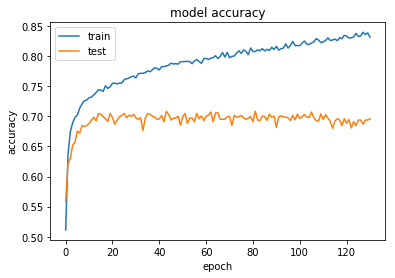

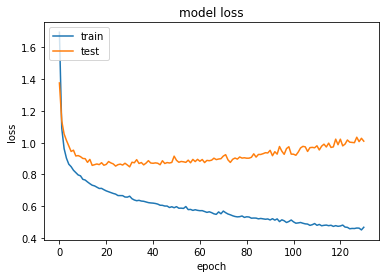

In [11]:
# train model with 1st features dataset
train_model(model1_sc, X1_scaled_train, y1_scaled_train, 600, 50, 0.3, calls1)

# load saved best model
saved_model1 = load_model('C:/Users/Kathleen Lange/MSDS692_Practicum_I/best_model1.h5')

In [12]:
print(saved_model1.count_params())
print(saved_model1.summary())

7094
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                1600      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 14)                574       
Total params: 7,094
Trainable params: 7,094
Non-trainable params: 0
_________________________________________________________________
None


The first model shows that the final accuracy is about 83%. However, the validation/testing data graph does not follow the training graph very well after the first few epochs. This probably means that the model is overfitting. To prevent overfitting there are a couple of algorithm tuning steps I could take including some of the following:
- Initialize class weights
- Change the activation function
- Change the number of batches and/or epochs
- Batch normalization between layers
- Change early stopping parameters

The second model performed worse given its los and accuracy. It also suffered from similar overfitting issues. From here forward, the primary focus will be on using the first feature set to complete the predictions on the test set.

## K-folds


One way to test the accuracy of the model is to use K-Fold cross validation. This splits the training dataset into k different sets/folds. The model is then trained on k-1 of the datasets and tests on the one set that is left out. To preserve the class distribution in each set, stratified k-folds are often used for classification problems. Once all of the fold have been trained to, then the final accuracy of the model is the average of the k different models. This [tutorial]( https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/) gives some beginner code on how to implement K-fold validation for a neural network.

For the time being, I chose to not implement K-folds as it did not add a very much accuracy or robustness to the current selected model. Also, I struggled with passing the model and callback parameters to the KerasClassifier wrapper function in order to try to optimize the algorithm as I desired. Leaving code here for the time being for use later.

## Accuracy per class

Next, find the probability given by the model that each of the testing data belongs to a certain class. The output is an array of values per class, where most of them are very close to zero and one of the classes is close to 1. The closer that a each object's single class value is to 1, the more accurate the model is as is shown in the classification matrices that follow.

In [13]:
X1_preds = saved_model1.predict_class(X1_scaled_train)
X1_probs = saved_model1.predict_proba(X1_scaled_train)
X1_probs

array([[5.6136992e-06, 3.9277054e-11, 7.8946687e-06, ..., 1.6957244e-12,
        9.9965668e-01, 6.7916340e-22],
       [1.3820649e-32, 2.8692089e-05, 2.3868450e-18, ..., 5.4269526e-22,
        1.2376733e-20, 9.2849214e-11],
       [5.8162775e-10, 2.6740329e-04, 5.5265890e-09, ..., 1.1385274e-01,
        7.8775175e-10, 3.3107522e-08],
       ...,
       [2.1080732e-05, 3.0388559e-08, 9.9988818e-01, ..., 8.4507551e-10,
        3.5530404e-06, 8.0525777e-25],
       [4.9446081e-10, 8.2270117e-13, 2.9472318e-14, ..., 4.5309246e-21,
        2.2114299e-09, 1.3729032e-25],
       [9.9968874e-01, 3.5233552e-05, 2.1110161e-07, ..., 4.2729233e-16,
        1.7382059e-05, 1.5410161e-10]], dtype=float32)

In [278]:
# code from this example: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
            
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd' # print 2 decimals if normalize, else print integer value
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [279]:
# Get confusion matrix
cm = confusion_matrix(X1_preds, np.argmax(y1_scaled_train, axis=-1))
np.set_printoptions(precision=2)

In [14]:
class_names = list(np.unique(feat_set1_scaled['target']))

Normalized confusion matrix


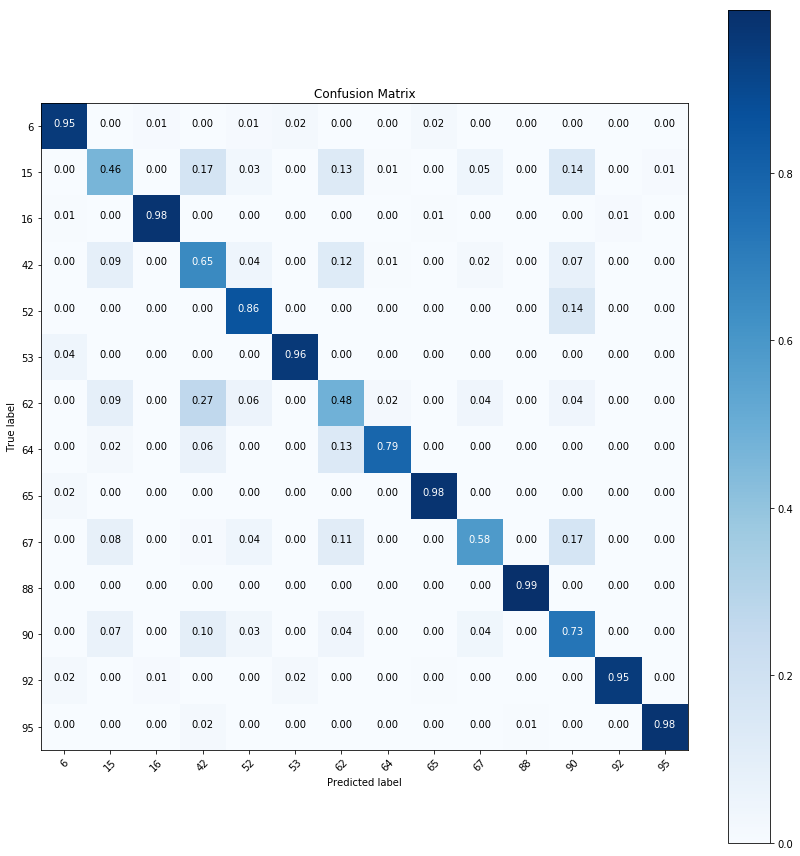

In [280]:
plt.figure(figsize=(12,12))
cm_plot = plot_confusion_matrix(cm, classes=class_names, normalize=True)

In [281]:
# code from this example:
# https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report/31689645#31689645

def plot_classification_report(cr, title, cmap=plt.cm.Blues):

    lines = cr.split('\n')
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:        
        t = line.split()       
        #classes.append(t[0])
        v = [float(x) for x in t[1: len(t)-1]]
        plotMat.append(v)

        
    plt.figure(figsize=(10,10))
    
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=90)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [282]:
class_rpt = classification_report(X1_preds, np.argmax(y1_scaled_train, axis=-1))
print(class_rpt)

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       128
           1       0.33      0.46      0.38       349
           2       0.99      0.98      0.99       938
           3       0.63      0.65      0.64      1154
           4       0.03      0.86      0.06         7
           5       0.73      0.96      0.83        23
           6       0.33      0.48      0.39       328
           7       0.86      0.79      0.82       112
           8       0.99      0.98      0.98       995
           9       0.25      0.58      0.35        89
          10       0.98      0.99      0.99       365
          11       0.93      0.73      0.82      2948
          12       0.96      0.95      0.96       242
          13       0.95      0.98      0.96       170

   micro avg       0.78      0.78      0.78      7848
   macro avg       0.70      0.81      0.72      7848
weighted avg       0.84      0.78      0.81      7848



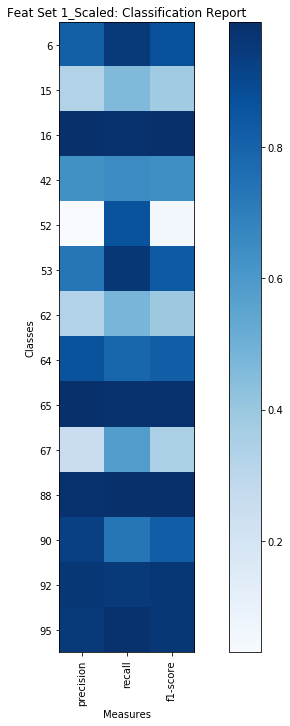

In [283]:
plot_classification_report(class_rpt, 'Feat Set 1_Scaled: Classification Report')

## Make Test Set Predictions

Due to the large file size of the test set (file containing the flux information) it must be read and processed in chunks based on memory constraints of my computer. As each chunk is read, features are created, the data is modeled and predictions are appended to csv file. The next four cells of code follow heavily from [Siddhartha's Kaggle kernel](https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification).

In [15]:
# read in meta-data for test set
test_meta = pd.read_csv(data_folder / 'plasticc_data/test_set_metadata.csv') 

# remove features that were determined to not be useful in previous analysis
test_meta.drop(columns = ['ra', 'decl', 'gal_l', 'gal_b'], inplace = True) 

In [84]:
def standardize_values(df_train, df_test):
    
    # ignore by message about converting to float64
    warnings.filterwarnings("ignore", message="Data with input dtype")
    
    # fill NaNs with mean of columns from training set
    train_mean = df_train.mean(axis=0)
    df_train.fillna(train_mean, inplace=True)
    
    # fit the standard scalar to the training values
    ss = StandardScaler()
    df_train_ss = ss.fit(df_train)
    
    # use the standard scalar fit to transform the test values
    df_test[df_train.columns] = df_test[df_train.columns].fillna(train_mean)
    df_test_ss = ss.transform(df_test[df_train.columns])

    return df_test

In [94]:
start = time.time()
chunk_size = 500000

for chunk_i, df in enumerate(pd.read_csv(data_folder / 'plasticc_data/test_set.csv', 
                                         chunksize=chunk_size, 
                                         iterator=True)):
    
    det_grp = df[df['detected'] == 1]
    det_grp_mjd = det_grp.groupby('object_id')['mjd']
    df['mjd_diff'] = det_grp_mjd.transform('max') - det_grp_mjd.transform('min') 
    
    df['flux_ratio_sq'] = np.power(df.flux / df.flux_err, 2.0) 
    df['flux_weight'] = df.flux * df.flux_ratio_sq 
    df['flux_weight_sum'] = df.groupby('object_id').flux_ratio_sq.transform('sum') 
    df['flux_rsq_sum'] = df.groupby('object_id').flux_weight.transform('sum') 
    df['flux_w_mean'] = df.flux_weight_sum / df.flux_rsq_sum 
    df['flux_median'] = df.groupby('object_id').flux.transform('median') 
    df['MAD'] = np.abs(df.flux - df.flux_median) / df.flux_w_mean 
    df['flux_diff'] = np.abs(df.flux - df.flux_w_mean) 

    # aggregate features
    aggs = {
        'object_id': ['count'],
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean','std'],
        'flux_ratio_sq': ['sum','skew'],
        'flux_weight': ['sum','skew'],
        'mjd_diff': ['mean'],
        'MAD': ['median'],
        'flux_diff': ['mean']
    }

    df_agg = df.groupby('object_id').agg(aggs)

    # create column names for new aggregate features
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    df_agg.columns = new_columns

    # additional computed features
    df_agg['flux_weighted_mean'] = df_agg['flux_weight_sum'] / df_agg['flux_ratio_sq_sum']
    df_agg['flux_amp'] = df_agg['flux_max'] - df_agg['flux_min']
    df_agg['flux_norm_amp_mean'] = (df_agg['flux_max'] - df_agg['flux_min']) / df_agg['flux_mean']
    df_agg['flux_norm_amp_w_mean'] = (df_agg['flux_max'] - df_agg['flux_min']) / df_agg['flux_weighted_mean']
    df_agg['beyond_1std'] = sum(df_agg['flux_diff_mean'] > df_agg['flux_std']) / df_agg['object_id_count']

    # delete unused objects
    del df_agg['object_id_count'], df_agg['flux_diff_mean']
    del df
    gc.collect()
    
    # merge with meta data
    full_df = test_meta.merge(df_agg, on='object_id')
    
    # transform fluxes based on redshift
    columns_to_divide = ['flux_min', 'flux_max', 
                        'flux_mean', 'flux_median', 
                        'flux_ratio_sq_sum', 'flux_weighted_mean', 
                        'flux_amp']
    new_column_names = ['flux_min_wz', 'flux_max_wz', 
                        'flux_mean_wz', 'flux_median_wz', 
                        'flux_ratio_sq_sum_wz', 'flux_weighted_mean_wz', 
                        'flux_amp_wz']
    new_df = full_df[columns_to_divide].div(full_df['hostgal_photoz'] + 1, axis=0) 
    new_df.columns = new_column_names       
    full_df = full_df.merge(new_df, left_index=True, right_index=True) 
    
    # standardize values and impute NaNs if applicable
    full_df_ss = standardize_values(full_df, X1_train)
    
    # make predictions
    probs = saved_model1.predict_proba(full_df_ss)

    # store predictions / class probabilities
    df_probs = pd.DataFrame(probs, columns=class_names)
    df_probs['object_id'] = full_df['object_id'] 
    
    if chunk_i == 0:
        df_probs.to_csv('predictions.csv',  header=True) # add headers if file doesn't previously exist
    else: 
        df_probs.to_csv('predictions.csv',  header=False, mode='a') # append data to file
        
    # delete data prior to next run through loop
    del df_agg, full_df, full_df_ss, df_probs, probs

    # after every 10 chunks, print progress of chunk reading 
    # print time (minutes) elapsed for number of lines in test_set file  
    if (chunk_i + 1) % 10 == 0: # add 1 because python indices start at 0
        print('%15d done in %5.1f min' % (chunk_size * (chunk_i + 1), (time.time() - start) / 60))

        5000000 done in   0.8 min
       10000000 done in   1.6 min
       15000000 done in   2.8 min
       20000000 done in   4.0 min
       25000000 done in   5.3 min
       30000000 done in   6.6 min
       35000000 done in   7.8 min
       40000000 done in   9.1 min
       45000000 done in  10.3 min
       50000000 done in  11.6 min
       55000000 done in  12.9 min
       60000000 done in  14.1 min
       65000000 done in  15.4 min
       70000000 done in  16.7 min
       75000000 done in  18.1 min
       80000000 done in  19.4 min
       85000000 done in  20.6 min
       90000000 done in  21.8 min
       95000000 done in  23.1 min
      100000000 done in  24.3 min
      105000000 done in  25.5 min
      110000000 done in  26.8 min
      115000000 done in  28.0 min
      120000000 done in  29.2 min
      125000000 done in  30.5 min
      130000000 done in  31.7 min
      135000000 done in  33.0 min
      140000000 done in  34.2 min
      145000000 done in  35.5 min
      15000000

In [96]:
z = pd.read_csv(data_folder /'predictions.csv')

print(z.groupby('object_id').size().max()) # maximum number of times an object_id is duplicated
print((z.groupby('object_id').size() > 1).sum()) # number objects that are duplicated

z = z.groupby('object_id').mean() # get the mean prediction/probability of the duplicated object_ids

z.to_csv('single_predictions.csv', index=True) # save new file with one prediction per object_id

2
901


In [97]:
final_preds = pd.read_csv(data_folder /'single_predictions.csv')
final_preds.drop(columns=['0'], inplace=True) # drop extra column
final_preds.set_index('object_id', inplace=True) # set object_id as index

In [212]:
final_dist = final_preds.round(0).sum(axis=0) # round to nearest int and then sum over each column
orig_list = ['orange', 'blue', 'orange', 'blue', 
             'blue', 'orange', 'blue', 'blue', 
             'orange', 'blue', 'blue', 'blue', 
             'orange', 'blue'] # set color values for galactic/extra- classes (to match EDA graph)

In [251]:
final_df = pd.DataFrame({'Sum_Predictions': final_dist, 'Origin': orig_list})

final_df['Class_Probability'] = final_df['Sum_Predictions'] / (final_df['Sum_Predictions'].sum())

with errstate(divide='ignore'):
    final_df['Log_Class'] = np.log(final_df['Sum_Predictions'])

final_df['Log_Class'][isneginf(final_df['Log_Class'])]=0 

,Sum_Predictions,Origin
6,2723.0,orange
15,0.0,blue
16,366612.0,orange
42,908.0,blue
52,0.0,blue
53,908.0,orange
62,1770.0,blue
64,3542.0,blue
65,205115.0,orange
67,0.0,blue


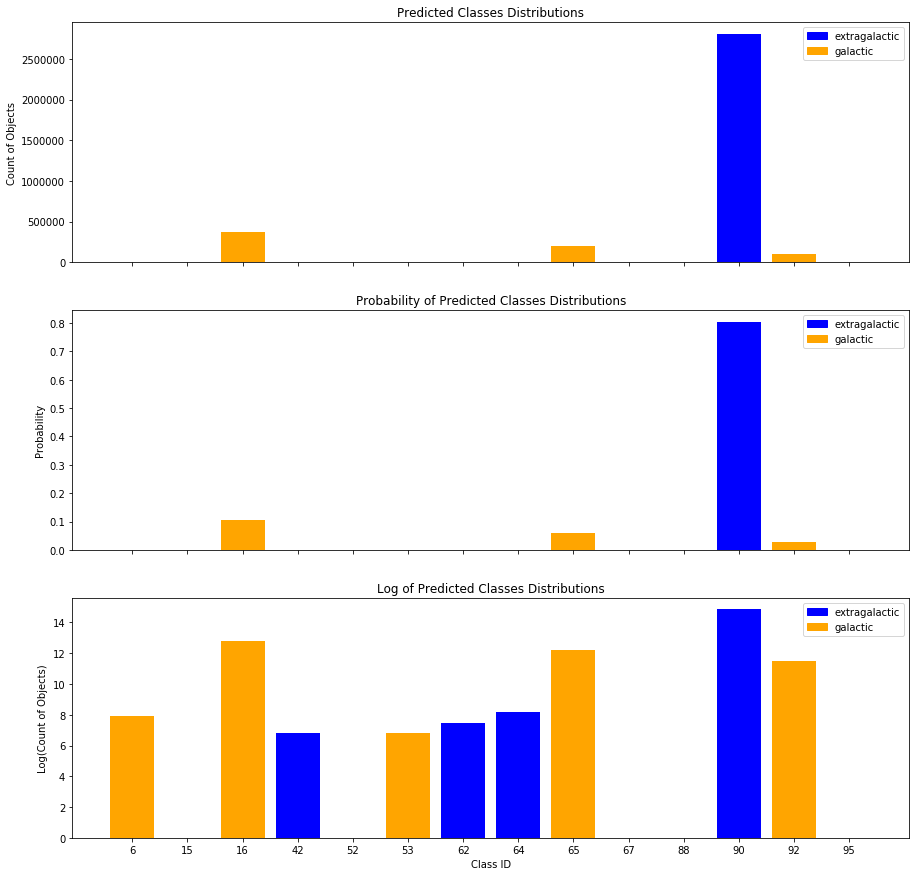

In [276]:
# visualize the above grouping
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,15), sharex=True)

blue = mpatches.Patch(color='blue', label='extragalactic')
orange = mpatches.Patch(color='orange', label='galactic')

ax1.bar(final_df.index, final_df.Sum_Predictions, color=final_df['Origin'])
ax1.set_title('Predicted Classes Distributions')
ax1.set_ylabel('Count of Objects')
ax1.legend(handles=[blue, orange], loc=1)

ax2.bar(final_df.index, final_df.Class_Probability, color=final_df['Origin'])
ax2.set_title('Probability of Predicted Classes Distributions')
ax2.set_ylabel('Probability')
ax2.legend(handles=[blue, orange], loc=1)

ax3.bar(final_df.index, final_df.Log_Class, color=final_df['Origin'])
ax3.set_title('Log of Predicted Classes Distributions')
ax3.set_ylabel('Log(Count of Objects)')
ax3.set_xlabel('Class ID')
ax3.legend(handles=[blue, orange], loc=1)

plt.show()